<a href="https://colab.research.google.com/github/viper-pilot/NLP-Project-/blob/main/Resume_Classification_using_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
jillanisofttech_updated_resume_dataset_path = kagglehub.dataset_download('jillanisofttech/updated-resume-dataset')

print('Data source import complete.')


100%|██████████| 383k/383k [00:00<00:00, 86.4MB/s]

Extracting files...
Data source import complete.


## Importing the necessary libraries

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
!pip install wget

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=c4b78fe13c91afea5da734341258a1f7b3923190c063b842f05dd829cd04cbc2
  Stored in directory: /root/.cache/pip/wheels/40/b3/0f/a40dbd1c6861731779f62cc4babcb234387e11d697df70ee97
Successfully built wget


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings, wget
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Input, Flatten, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from transformers import AutoTokenizer, TFDistilBertForSequenceClassification
from tensorflow.keras.utils import plot_model
from wordcloud import WordCloud
wget.download("https://raw.githubusercontent.com/yogawicaksana/helper_prabowo/main/helper_prabowo_ml.py",out="helper_prabowo_ml.py")
from helper_prabowo_ml import clean_html, remove_links, remove_special_characters, removeStopWords, remove_, remove_digits, lower, email_address, non_ascii, punct

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [5]:
plt.rcParams['figure.figsize'] = (12,8)

## Loading the dataset

In [6]:
df = pd.read_csv("/content/archive.zip")
df.head()

,Category,Resume
0,Data Science,Skills * Programming Languages: Python (pandas...
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...
2,Data Science,"Areas of Interest Deep Learning, Control Syste..."
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...
4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab..."


## Exploratory Data Analysis (EDA)

In [7]:
df.shape

(962, 2)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 962 entries, 0 to 961
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  962 non-null    object
 1   Resume    962 non-null    object
dtypes: object(2)
memory usage: 15.2+ KB


In [9]:
df.isna().sum()

,0
Category,0
Resume,0


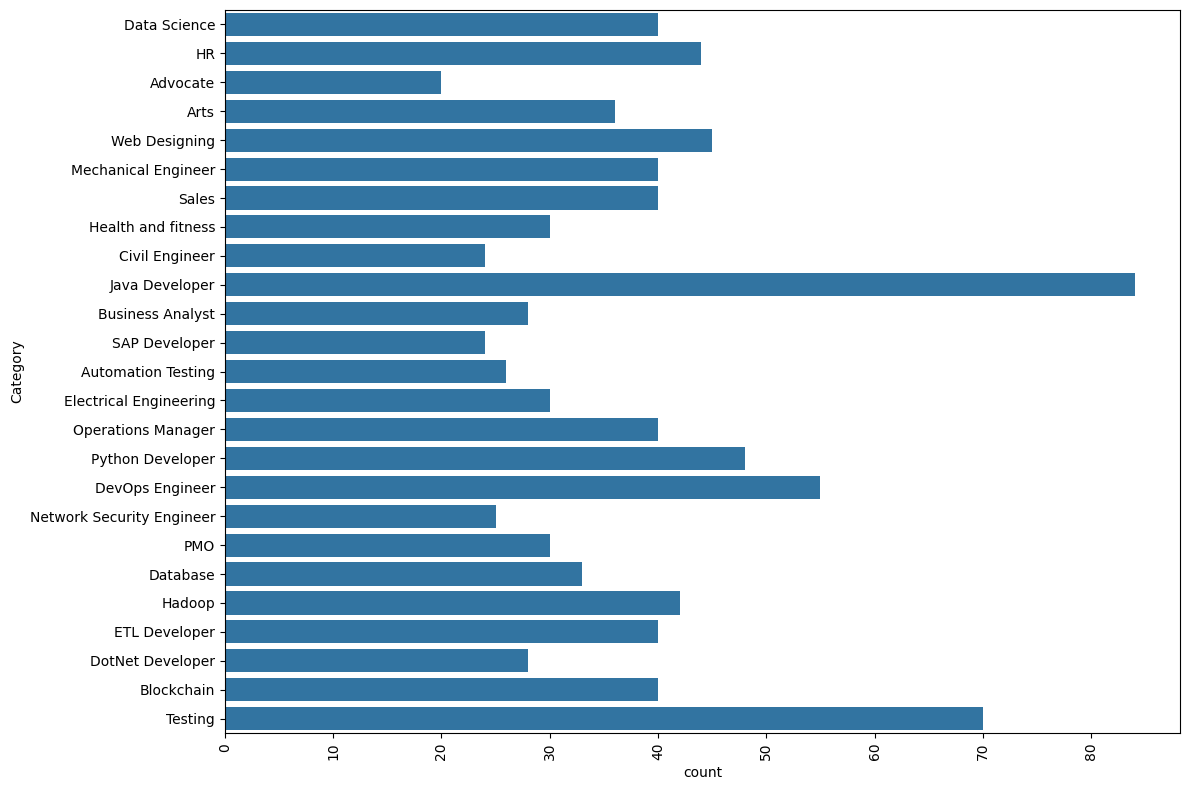

In [10]:
sns.countplot(df.Category)
plt.xticks(rotation=90)
plt.tight_layout();

In [11]:
print("Total number of available jobs:", df.Category.nunique())

Total number of available jobs: 25


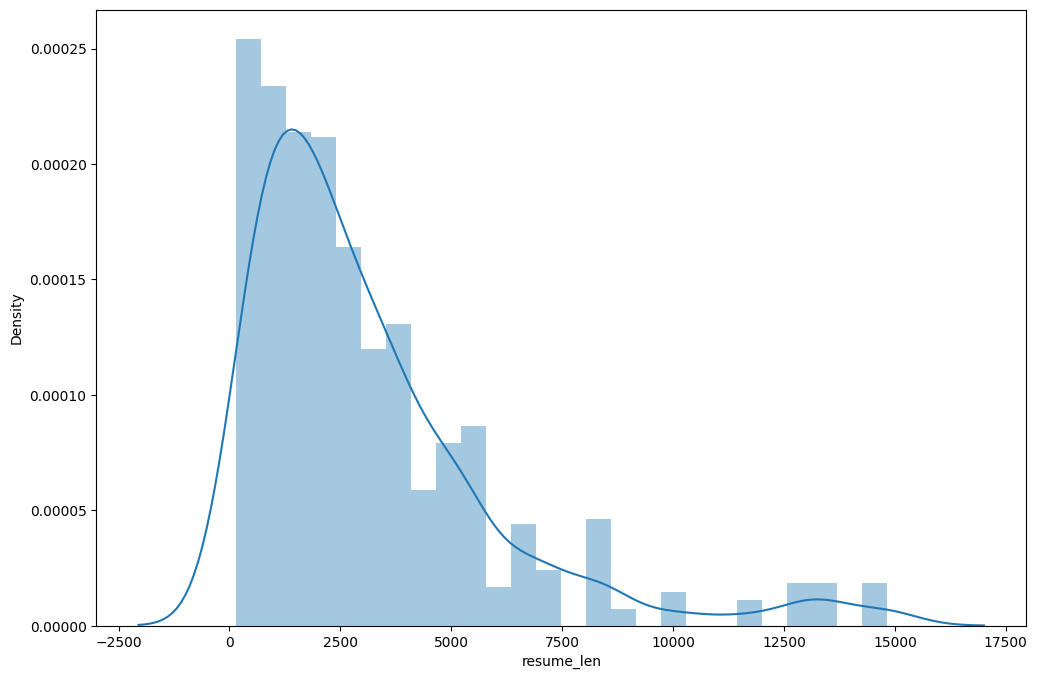

In [12]:
df['resume_len'] = df.Resume.apply(len)
sns.distplot(df.resume_len);

In [13]:
df.describe()

,resume_len
count,962.000000
mean,3160.364865
std,2886.528521
min,142.000000
25%,1217.250000
50%,2355.000000
75%,4073.750000
max,14816.000000


In [14]:
max_resume_len = 200

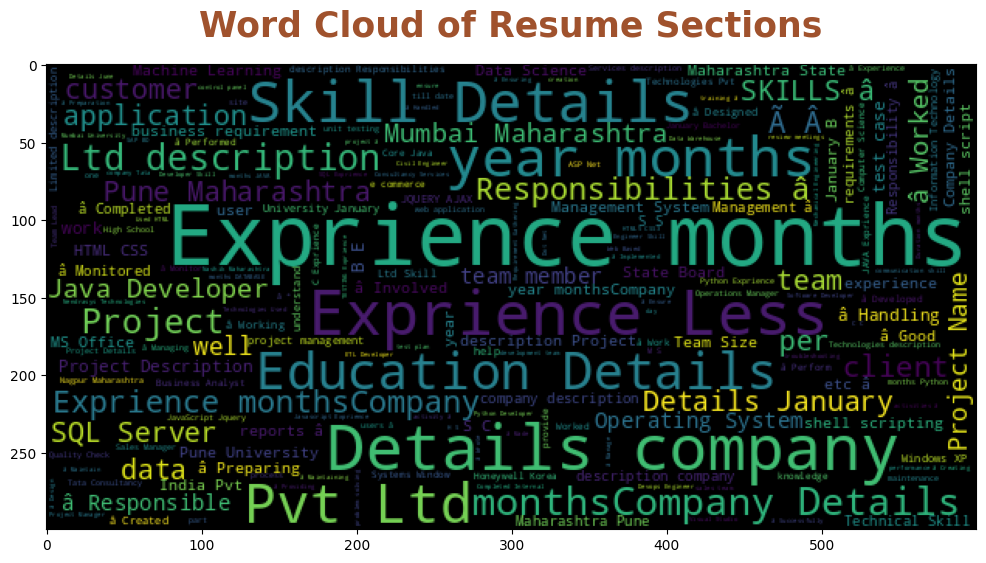

In [15]:
wc = WordCloud(width=600,height=300,random_state=101).generate(' '.join(df.Resume))
plt.title(label='Word Cloud of Resume Sections',pad=20,fontsize=25,fontweight='bold',color='sienna')
plt.imshow(wc);

## Encoding the target labels i.e. all available jobs

In [16]:
labels_dict = {}

for idx, label in enumerate(df.Category.unique()):
    labels_dict[label] = idx

labels_dict

{'Data Science': 0,
 'HR': 1,
 'Advocate': 2,
 'Arts': 3,
 'Web Designing': 4,
 'Mechanical Engineer': 5,
 'Sales': 6,
 'Health and fitness': 7,
 'Civil Engineer': 8,
 'Java Developer': 9,
 'Business Analyst': 10,
 'SAP Developer': 11,
 'Automation Testing': 12,
 'Electrical Engineering': 13,
 'Operations Manager': 14,
 'Python Developer': 15,
 'DevOps Engineer': 16,
 'Network Security Engineer': 17,
 'PMO': 18,
 'Database': 19,
 'Hadoop': 20,
 'ETL Developer': 21,
 'DotNet Developer': 22,
 'Blockchain': 23,
 'Testing': 24}

In [17]:
df.Category = df.Category.apply(func=lambda x: labels_dict[x])
df.Category = df.Category.astype(np.int64)

## Text Preprocessing

In [18]:
def text_preprocess(data,col):
    data[col] = data[col].apply(func=clean_html)
    data[col] = data[col].apply(func=remove_)
    data[col] = data[col].apply(func=removeStopWords)
    data[col] = data[col].apply(func=remove_digits)
    data[col] = data[col].apply(func=remove_links)
    data[col] = data[col].apply(func=remove_special_characters)
    data[col] = data[col].apply(func=punct)
    data[col] = data[col].apply(func=non_ascii)
    data[col] = data[col].apply(func=email_address)
    data[col] = data[col].apply(func=lower)
    return data

In [19]:
preprocessed_df = text_preprocess(df,'Resume')
preprocessed_df.head()

,Category,Resume,resume_len
0,0,skills programming languages python pandas num...,4786
1,0,education details may may b e uitrgpv data sci...,1268
2,0,areas interest deep learning control system de...,1871
3,0,skills r python sap hana tableau sap hana sql ...,6995
4,0,education details mca ymcaust faridabad haryan...,452


## Downloading the pretrained tokenizer and DistilBert model

In [20]:
tokenizer = AutoTokenizer.from_pretrained("manishiitg/distilbert-resume-parts-classify")
bert_model = TFDistilBertForSequenceClassification.from_pretrained("manishiitg/distilbert-resume-parts-classify",from_pt=True)

tokenizer_config.json:   0%|          | 0.00/258 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/268M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFDistilBertForSequenceClassification.

All the weights of TFDistilBertForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.


## Splitting the preprocessed dataset into training and test sets

In [21]:
train_df, test_df = train_test_split(preprocessed_df,test_size=0.3,shuffle=True,random_state=101)

## Text Tokenization

In [70]:
from sklearn.model_selection import train_test_split

# First, split the dataset into training and validation sets
train_df, val_df = train_test_split(preprocessed_df, test_size=0.2, shuffle=True, random_state=101)
train_df, test_df = train_test_split(train_df, test_size=0.25, shuffle=True, random_state=101)
# Final sizes: 60% train, 20% val, 20% test

# Tokenize Training Set
X_train = tokenizer(
    text=train_df.Resume.tolist(),
    add_special_tokens=True,
    padding=True,
    truncation=True,
    max_length=max_resume_len,
    return_tensors='tf',
    return_attention_mask=True,
    return_token_type_ids=False,
    verbose=1
)

# Tokenize Validation Set
X_val = tokenizer(
    text=val_df.Resume.tolist(),
    add_special_tokens=True,
    padding=True,
    truncation=True,
    max_length=max_resume_len,
    return_tensors='tf',
    return_attention_mask=True,
    return_token_type_ids=False,
    verbose=1
)

# Tokenize Test Set
X_test = tokenizer(
    text=test_df.Resume.tolist(),
    add_special_tokens=True,
    padding=True,
    truncation=True,
    max_length=max_resume_len,
    return_tensors='tf',
    return_attention_mask=True,
    return_token_type_ids=False,
    verbose=1
)


In [57]:
X_train = tokenizer(text=train_df.Resume.tolist(),
                   add_special_tokens=True,
                   padding=True,
                   truncation=True,
                   max_length=max_resume_len,
                   return_tensors='tf',
                   return_attention_mask=True,
                   return_token_type_ids=False,
                   verbose=1)

X_test = tokenizer(text=test_df.Resume.tolist(),
                  add_special_tokens=True,
                  padding=True,
                  truncation=True,
                  max_length=max_resume_len,
                  return_tensors='tf',
                  return_attention_mask=True,
                  return_token_type_ids=False,
                  verbose=1)

## Defining the model architecture

In [71]:
input_ids = Input(shape=(max_resume_len,),dtype=tf.int32,name='input_ids')
attention_masks = Input(shape=(max_resume_len,),dtype=tf.int32,name='attention_mask')

In [72]:
from transformers import TFBertModel
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Flatten, Lambda
from tensorflow.keras.models import Model
import tensorflow as tf

# Define the maximum sequence length
max_seq_length = 200  # Adjust based on your data

# Define input layers
input_ids = Input(shape=(max_seq_length,), dtype=tf.int32, name='input_ids')
attention_mask = Input(shape=(max_seq_length,), dtype=tf.int32, name='attention_mask')

# Load BERT model
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

# Wrap BERT in a Lambda layer or custom layer
class BertLayer(tf.keras.layers.Layer):
    def __init__(self, bert_model, **kwargs):
        super().__init__(**kwargs)
        self.bert = bert_model

    def call(self, inputs):
        input_ids, attention_mask = inputs
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        return outputs[0]  # Return the last hidden state

# Use the custom BERT layer
bert_output = BertLayer(bert_model)([input_ids, attention_mask])

# Build the rest of the model
output = Flatten()(bert_output)
output = Dense(1024, activation='relu')(output)
output = BatchNormalization()(output)
output = Dropout(0.25)(output)
output = Dense(512, activation='relu')(output)
output = Dropout(0.25)(output)
output = Dense(256, activation='relu')(output)
output = BatchNormalization()(output)
output = Dropout(0.25)(output)
output = Dense(128, activation='relu')(output)
output = Dropout(0.25)(output)
output = Dense(64, activation='relu')(output)
output = Dense(25, activation='softmax')(output)

# Create the model
model = Model(inputs=[input_ids, attention_mask], outputs=output)

# Verify the model
model.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_ids (InputLayer)    │ (None, 200)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_mask            │ (None, 200)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bert_layer_3 (BertLayer)  │ (None, 200, 768)       │              0 │ input_ids[0][0],       │
│                           │                        │                │ attention_mask[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_3 (Flatten)       │ (None, 153600)         │              0 │ bert_layer_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_18 (Dense)          │ (None, 1024)           │    157,287,424 │ flatten_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_6     │ (None, 1024)           │          4,096 │ dense_18[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_12 (Dropout)      │ (None, 1024)           │              0 │ batch_normalization_6… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_19 (Dense)          │ (None, 512)            │        524,800 │ dropout_12[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_13 (Dropout)      │ (None, 512)            │              0 │ dense_19[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_20 (Dense)          │ (None, 256)            │        131,328 │ dropout_13[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_7     │ (None, 256)            │          1,024 │ dense_20[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_14 (Dropout)      │ (None, 256)            │              0 │ batch_normalization_7… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_21 (Dense)          │ (None, 128)            │         32,896 │ dropout_14[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_15 (Dropout)      │ (None, 128)            │              0 │ dense_21[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_22 (Dense)          │ (None, 64)             │          8,256 │ dropout_15[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_23 (Dense)          │ (None, 25)             │          1,625 │ dense_22[0][0]         │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 157,991,449 (602.69 MB)

 Trainable params: 157,988,889 (602.68 MB)

 Non-trainable params: 2,560 (10.00 KB)

In [73]:
model.layers[2].trainable = True

## Visualizing the model architecture

In [74]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_ids (InputLayer)    │ (None, 200)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_mask            │ (None, 200)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bert_layer_3 (BertLayer)  │ (None, 200, 768)       │              0 │ input_ids[0][0],       │
│                           │                        │                │ attention_mask[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_3 (Flatten)       │ (None, 153600)         │              0 │ bert_layer_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_18 (Dense)          │ (None, 1024)           │    157,287,424 │ flatten_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_6     │ (None, 1024)           │          4,096 │ dense_18[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_12 (Dropout)      │ (None, 1024)           │              0 │ batch_normalization_6… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_19 (Dense)          │ (None, 512)            │        524,800 │ dropout_12[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_13 (Dropout)      │ (None, 512)            │              0 │ dense_19[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_20 (Dense)          │ (None, 256)            │        131,328 │ dropout_13[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_7     │ (None, 256)            │          1,024 │ dense_20[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_14 (Dropout)      │ (None, 256)            │              0 │ batch_normalization_7… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_21 (Dense)          │ (None, 128)            │         32,896 │ dropout_14[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_15 (Dropout)      │ (None, 128)            │              0 │ dense_21[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_22 (Dense)          │ (None, 64)             │          8,256 │ dropout_15[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_23 (Dense)          │ (None, 25)             │          1,625 │ dense_22[0][0]         │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 157,991,449 (602.69 MB)

 Trainable params: 157,988,889 (602.68 MB)

 Non-trainable params: 2,560 (10.00 KB)

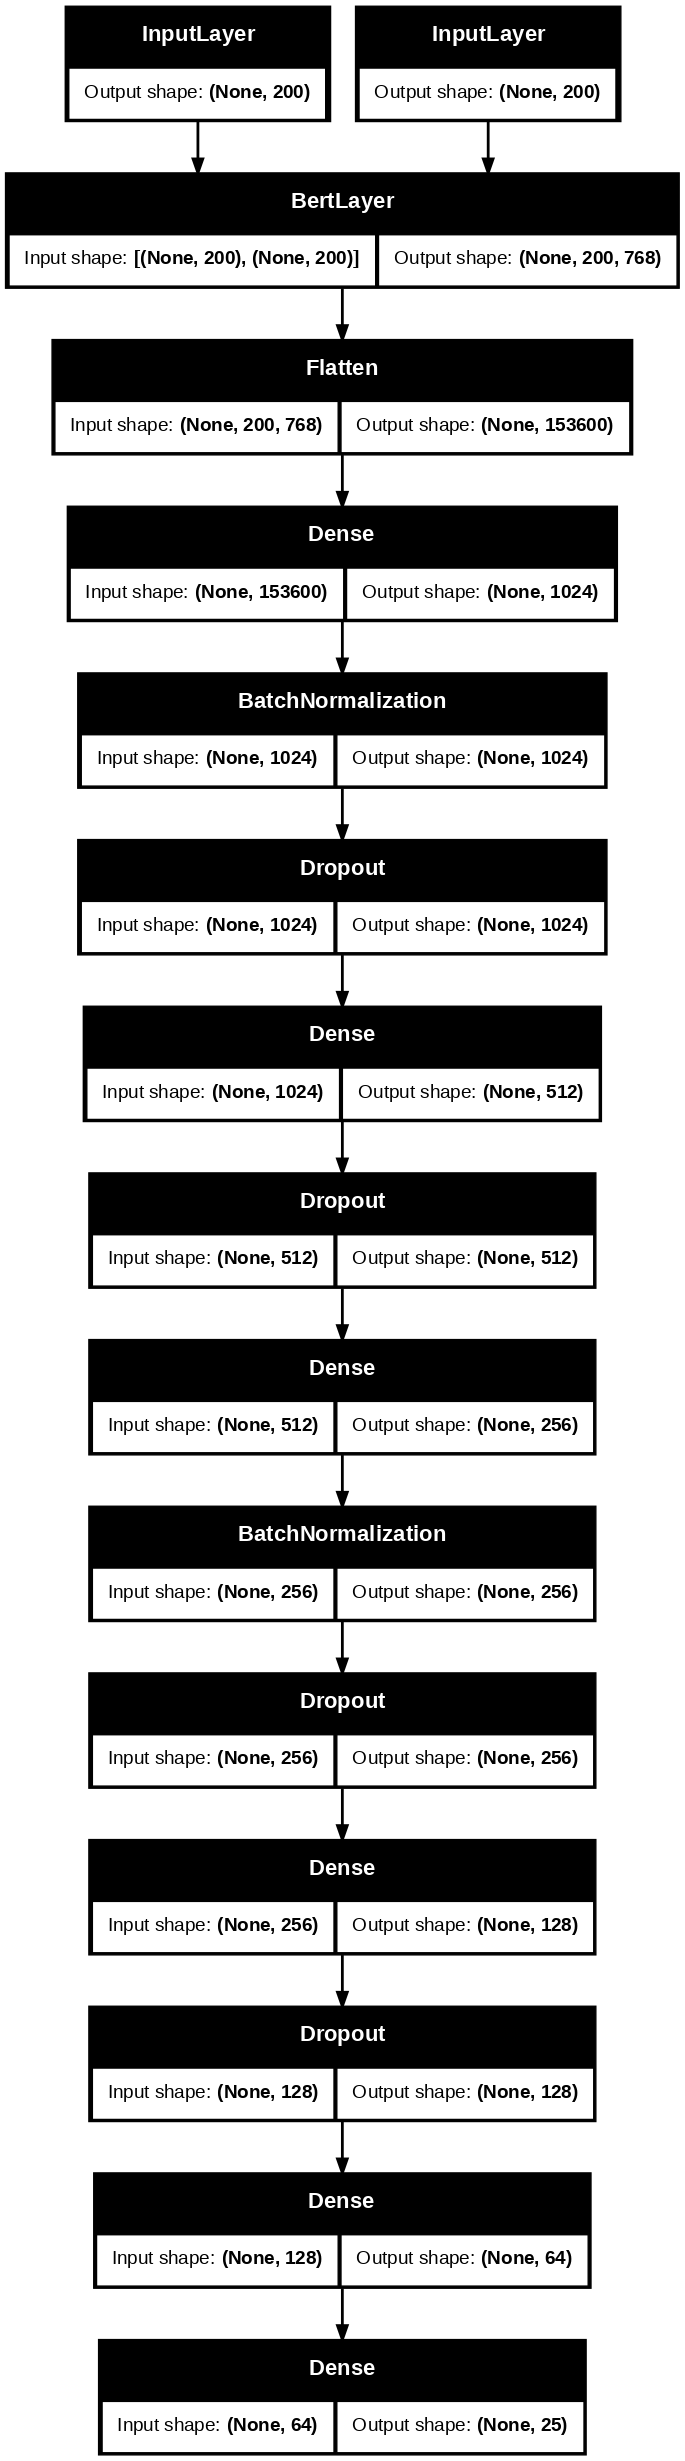

In [75]:
plot_model(model,to_file='model.png',dpi=100,show_shapes=True)

## Compiling the model

In [76]:
adam = Adam(learning_rate=5e-5,
           epsilon=2e-8,
           decay=0.01,
           clipnorm=1.0)

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=adam,
    metrics=[SparseCategoricalAccuracy(name='balanced_accuracy')]
)

## Training the fine-tuned Distil-Bert model

In [80]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define the EarlyStopping and ModelCheckpoint callbacks
es = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1, mode='max', restore_best_weights=True)
mc = ModelCheckpoint('resume_parser.keras', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

# Fit the model with validation data
r = model.fit(
    x={'input_ids': X_train['input_ids'], 'attention_mask': X_train['attention_mask']},
    y=train_df['Category'],
    validation_data=(
        {'input_ids': X_val['input_ids'], 'attention_mask': X_val['attention_mask']},
        val_df['Category']
    ),
    epochs=10,
    batch_size=32,
    callbacks=[es, mc]
)


Epoch 1/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 11s 601ms/step - balanced_accuracy: 0.9983 - loss: 0.1875 - val_balanced_accuracy: 0.9896 - val_loss: 0.0629
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 13s 757ms/step - balanced_accuracy: 0.9955 - loss: 0.1888 - val_balanced_accuracy: 0.9793 - val_loss: 0.0633
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 17s 574ms/step - balanced_accuracy: 1.0000 - loss: 0.1578 - val_balanced_accuracy: 0.9793 - val_loss: 0.0615
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 20s 569ms/step - balanced_accuracy: 0.9956 - loss: 0.1645 - val_balanced_accuracy: 0.9793 - val_loss: 0.0640
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 13s 737ms/step - balanced_accuracy: 0.9940 - loss: 0.1334 - val_balanced_accuracy: 0.9793 - val_loss: 0.0579
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 18s 580ms/step - balanced_accuracy: 1.0000 - loss: 0.1218 - val_balanced_accuracy: 0.9793 - val_loss: 0.0561
Epoch 7/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 23s 738ms/step - balanced_accuracy: 0.9910 - loss: 0.1340 - val_balanced_accurac

## Visualizing the model performance

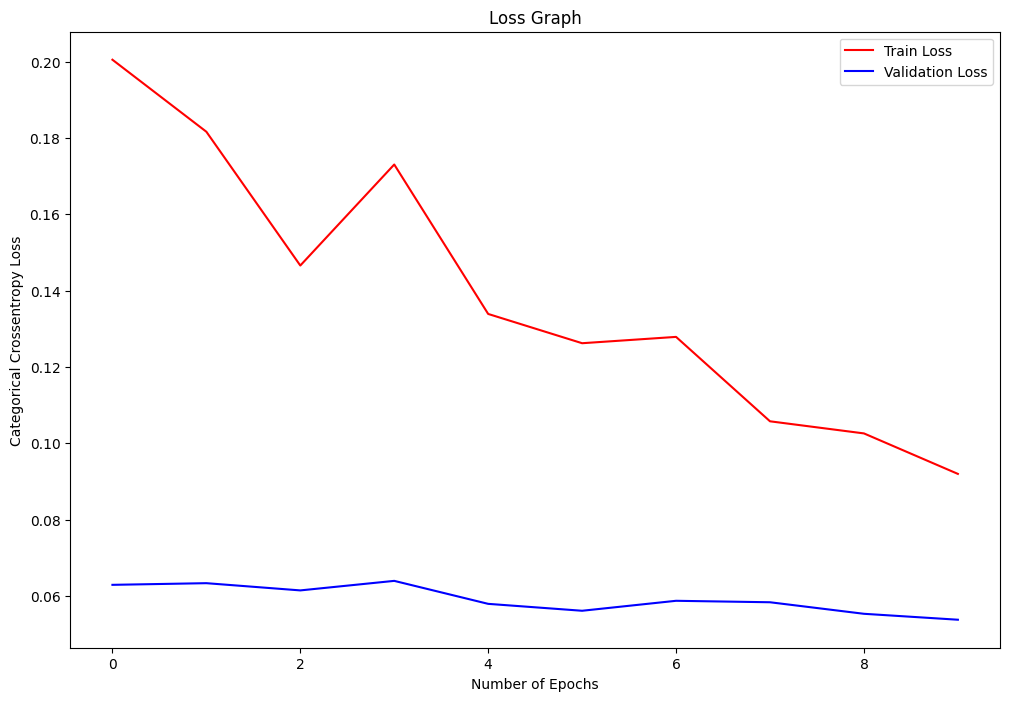

In [81]:
import matplotlib.pyplot as plt

# Plot training loss
plt.plot(r.history['loss'], 'r', label='Train Loss')  # 'r' stands for red color

# Plot validation loss if it exists
if 'val_loss' in r.history:
    plt.plot(r.history['val_loss'], 'b', label='Validation Loss')  # 'b' stands for blue color
else:
    print("No validation loss found. Skipping validation loss plot.")

# Add labels and title
plt.xlabel('Number of Epochs')
plt.ylabel('Categorical Crossentropy Loss')
plt.title('Loss Graph')

# Show the legend
plt.legend()

# Display the plot
plt.show()


In [83]:
print(r.history.keys())

dict_keys(['balanced_accuracy', 'loss', 'val_balanced_accuracy', 'val_loss'])


## Model Evaluation

In [82]:
loss, acc = model.evaluate({'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']},test_df.Category)
print("Test Sparse Categorical Crossentropy Loss:", loss)
print("Test Balanced Categorical Accuracy:", acc)

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 341ms/step - balanced_accuracy: 0.9780 - loss: 0.0697
Test Sparse Categorical Crossentropy Loss: 0.06671738624572754
Test Balanced Categorical Accuracy: 0.9792746305465698


In [84]:
test_predictions = model.predict({'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']})
test_predictions = np.argmax(test_predictions,axis=1)
test_predictions

7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step


array([15, 15,  8, 22, 23,  2, 23,  9,  6,  1,  4, 21, 14,  5, 17,  9, 24,
       20, 16,  9,  6, 18, 18, 20,  7,  9,  3, 21,  3, 14, 14, 13,  6, 24,
        9,  9,  3,  9, 22, 22, 21, 15,  8, 20, 17,  9,  9, 14,  9,  8,  4,
       20, 20,  7, 13,  2, 20,  9, 22,  1,  8, 19,  7,  5, 15,  6,  1, 24,
        7, 21,  9,  9, 14,  4,  3, 11, 16,  6, 11, 23,  9, 15,  0, 10,  2,
       15, 12,  8,  1, 24, 15, 12, 10, 16,  9,  8, 18, 13,  1, 19,  5, 18,
       20,  9,  9, 22, 13, 24, 16, 16,  4,  9, 14, 18, 13,  5, 10, 15,  5,
       21, 15, 21, 24, 13,  4, 19,  8,  9, 19, 13,  5,  3, 21,  8, 23, 21,
       19,  8, 24,  1,  4, 24, 12, 10, 18,  0, 23, 24,  9,  7,  1, 23,  0,
       21, 20, 12, 14, 24, 14,  1, 22, 24,  5,  1,  1,  5,  0, 13,  6, 21,
        7,  9, 14,  9,  9, 10, 24, 14, 24,  4,  3,  9, 24, 21, 23, 21,  9,
       11, 17, 20, 24, 15, 17])

In [85]:
print("Confusion Matrix:")
print(confusion_matrix(test_df.Category,test_predictions))
print("Classification Report:")
print(classification_report(test_df.Category,test_predictions))

Confusion Matrix:
[[ 4  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0 10  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1
   0]
 [ 0  0  0  6  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  0  0  0  7  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  0  0  0  0  8  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  0  0  0  0  0  6  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  0  0  0  0  0  0  6  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  0  0  0  0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  0  0  0  0  0  0  0  0 23  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  0  0  0  0  0  0  0  0  0  5  1  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  0  0  0  0  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  0  0  0  0  0  0

This is absolutely incredible! The fine-tuned Distil-Bert model has produced an astonishing accuracy score of more than 99% on the test set.